# DL Indaba Practical 5
# Variational Auto-Encoders
*Developed by Stephan Gouws, Avishkar Bhoopchand & Ulrich Paquet.*

**Background**

In this practical, our only aim is for you to understand what a variational auto-encoder (VAE) is. Some people prefer to call it "auto-encoding variational Bayes", which is technically more correct.

If you are mathematically inclined, you are welcome to look at https://arxiv.org/pdf/1312.6114.pdf, but it is not neccessary for the scope of this practical.

**Learning objectives**

Our only aim for this practical is that you understand some key concepts:

* What is meant by the posterior $p_{\theta}(z|x)$, and why it's hard (intractable) to compute from $p_{\theta}(x|z)$ and $p(z)$.
* What is meant by an approximation to the posterior, $q_{\phi}(z|x)$.
* How we find a good approximation via a cleverly constructed optimization problem.

**What is expected of you?**

1. Run through all the cells below, in order, and consider the output. You should see a loss that becomes smaller and smaller, and some images that will, over time, start resembling MNIST digits.
2. Once you've seen the final output, step through the cells again, top to bottom. As you do this, try to answer all the questions as they arise.




In [1]:
import itertools
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import time

from matplotlib import pyplot as plt

import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data

sg = tf.contrib.bayesflow.stochastic_graph
st = tf.contrib.bayesflow.stochastic_tensor
distributions = tf.contrib.distributions


In [2]:
tf.reset_default_graph()

try:
    flags = tf.app.flags
    flags.DEFINE_string('data_dir', '/tmp/dat/', 'Directory for data')
    flags.DEFINE_string('logdir', '/tmp/log/', 'Directory for logs')

    flags.DEFINE_integer('latent_dim', 100, 'Latent dimensionality of model')
    flags.DEFINE_integer('batch_size', 64, 'Minibatch size')
    flags.DEFINE_integer('n_samples', 1, 'Number of samples to save')
    flags.DEFINE_integer('print_every', 1000, 'Print every n iterations')
    flags.DEFINE_integer('hidden_size', 200, 'Hidden size for neural networks')
    # flags.DEFINE_integer('n_iterations', 1, 'number of iterations')
except:
    pass

FLAGS = flags.FLAGS

# Flags are immutable once defined. If you were to ever run big experiments,
# you'd use something like FLAGS.n_iterations, but as you want to try things in
# the cells below, we'll just make n_iterations something that you can change
# to easily re-run.

N_ITERATIONS = 10000


Before continuing, you'll have to sharpen your mental mathematical pencils, and step through a derivation that you've encountered in the Deep Generative Models lecture.

# An "evidence lower bound" (ELBO)

"Evidence? Of what?," you might ask. The term is short for "model evidence" $p_{\theta}(x)$ and specifies how well the model supports the data point $x$. A more common term is "marginal likelihood", as we obtain it by marginalizing (or integrating or summing) out $z$ from $p_{\theta}(x, z)$.

Bayes's theorem states that

\begin{align}
p_{\theta}(z|x) & = \frac{p_{\theta}(x|z) \, p(z)}{p_{\theta}(x)} \\
\textrm{posterior} & = \frac{\textrm{likelihood} \times \textrm{prior}}{\textrm{evidence (or marginal likelihood)}}
\end{align}

and the denominator is an average of the likelihood over all prior assignments of $z$. Of course we can't compute it in most cases, and will find a way to approximate it as best we could.

**What would we like to optimize?**

We would like to optimize $\log p_{\theta}(x)$ over $\theta$. It's the best description of the data, averaged over all prior settings of $z$. But we cannot compute it. Oh dear!

If we were able to compute $p_{\theta}(x)$, we would normally also be able to compute the true posterior $p_{\theta}(z | x)$. These two are intimately tied.
Let's say we want to know which settings of $z$ were responsible for generating the $x$ that we see.
Instead of doing exact inference with $p_{\theta}(z | x)$ (which is hard as we have to invert a complicated generative process) we will approximate it with another distribution $q_{\phi}(z | x) \approx p_{\theta}(z | x)$.

**A lower bound, a.k.a. "sensible approximations rock!"**

For every data point (or MNIST image) $x$, we define the bound on the log marginal likelihood -- or ELBO -- as:

\begin{align}
\log p_{\theta}(x) & = \log \int p_{\theta}(x, z) \, \mathrm{d} z \\
& = \log \int p_{\theta}(x | z) \, p(z) \, \mathrm{d} z \\
& = \log \int q_{\phi}(z | x) \left[ \frac{ p_{\theta}(x | z) \, p(z) }{q_{\phi}(z | x)} \right] \mathrm{d} z \\
& \ge \int q_{\phi}(z | x) \log \left[ \frac{ p_{\theta}(x | z) \, p(z) }{q_{\phi}(z | x)} \right] \mathrm{d} z && \triangleright \textrm{Jensen's Inequality.}\\
& = \mathbb{E}_{q_{\phi}(z|x)}\Big[ \log p_{\theta}(x | z) + \log p(z) - \log q_{\phi}(z | x)\Big] \\
& \equiv \mathcal{L}(\theta, \phi)
\end{align}

The inequality arises due to [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality), since logs are convex functions. So, instead of maximizing $\log p_{\theta}(x)$ as a function of $\theta$, we will maximize $\mathcal{L}(\theta, \phi)$ as a function of both $\theta$ and $\phi$.

We have a few pieces:
1. The likelihood $p_{\theta}(x | z)$, also called the "generative network". It is sometimes called the "decoder" as it "decodes" $x$ from $z$.
2. The variational approximation $q_{\phi}(z | x)$, also called the "inference network". Sometimes it is called the "encoder", as it "encodes" $x$ into $z$.

In the code below, we are going to define $p_{\theta}(x | z)$ and $q_{\phi}(z | x)$.

**Take a breather**

Explain to your neighbour what is going on here. Is there anything that you don't understand?

**Deep dive 101**

Your challenge is to find how $\theta$ and $\phi$ are represented in the code.
1. What are they?
2. Where are they?
Try to answer the other questions in the code below.

Note that in the code, there are many images $x$ that are stacked in a batch x. The bound refers to one such image, and we assume that they are generated i.i.d., we sum the bounds...

In [3]:
def inference_network(x, latent_dim, hidden_size):
    """Construct an inference network q(z|x).

    Args:
        x: A batch of MNIST digits.
        latent_dim: The latent dimensionality of z.
        hidden_size: The size of the neural net hidden layers.
    Returns:
        mu: The mean of q(z|x)
        sigma: The component-wise standard deviation of q(z|x)
    """    
        
    with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu):
        
        # Question: What is the shape of x as you run the code with MNIST images?
        # Hint: You might have to put a `print(net.get_shape())` somewhere around
        #             here, run the `train()` cell to contruct the TF graph, and see what
        #             you get. Debugging is part of life!
        # Answer: ....

        net = slim.flatten(x)        
        
        # Question: Now that we've flattened x, what is its shape now, as `net`?        
        # Answer: ...
        
        # At this point, `net` contains the input to the network. We will now
        # transform it layer-by-layer:
        
        net = slim.fully_connected(net, hidden_size)
        
        # Question: What is the shape of the first layer, as `net`?
        # Answer: ...

        # Question: Write down the mathematical expression for
        #        net = slim.fully_connected(net, hidden_size). It it was not wrapped in
        #        "with slim.arg_scope(..., activation_fn=tf.nn.relu)", would the
        #        mathematical expression look different? Why?
        #
        # Hint: If "l" indicates this layer, then we can either say
        #        output = weights_l * input + biases_l        or
        #        output = relu(weights_l * input + biases_l)
        # Answer: ...
        
        # Question: How does it differ from the network that you devised in the
        #        Deep Generative Models lecuture?
        # Answer: ...
        
        net = slim.fully_connected(net, hidden_size)
        
        # Question: What is the shape of the second layer, as `net`?
        # Answer: ...
        
        gaussian_params = slim.fully_connected(
                net, latent_dim * 2, activation_fn=None)
        
        # Question: What is the shape of the third (output) layer,
        #        `gaussian_params`?        
        # Answer: ...
    
    # We're taking the output of the MLP (multi-layer perceptron) and split it
    # into two parts: the first latent_dim outputs become the means, while the
    # second latent_dim outputs become the standard deviations.
    
    # Challenge 1. Can you write the entire network as a mathematical function?
    # Challenge 2. Can you draw it?
    # Challenge 3. Can you say which parameters constitute \phi?
    #
    # Challenge 4. (You can skip this challenge and do it at home).
    #                            Can you see it in the actual computation graph?
    #                            Hint: You can write the graph to file with
    #
    #                            tf.train.write_graph(tf.get_default_graph().as_graph_def(),
    #                                                                     directory, 'mygraph.pbtxt')
    
    # The mean parameter is unconstrained
    mu = gaussian_params[:, :latent_dim]
    
    # The standard deviation must be positive. Parametrize with a softplus and
    # add a small epsilon for numerical stability
    sigma = 1e-6 + tf.nn.softplus(gaussian_params[:, latent_dim:])
        
    # Question: Can you draw the softplus function, log(exp(inputs) + 1)?
    # Answer: ...

    return mu, sigma


def generative_network(z, hidden_size):
    """Build a generative network to return the logits of p(x|z).

    Args:
        z: Samples of latent variables.
        hidden_size: Size of the hidden state of the neural net.

    Returns:
        bernoulli_logits: logits for the Bernoulli likelihood of the data.
    """
    with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu):
        
        net = slim.fully_connected(z, hidden_size)
        net = slim.fully_connected(net, hidden_size)
        bernoulli_logits = slim.fully_connected(net, 784, activation_fn=None)
        bernoulli_logits = tf.reshape(bernoulli_logits, [-1, 28, 28, 1])
        
        # Challenge 5. Can you again write the entire network as a mathematical
        #                            function, draw it, and say which parameters constitute
        #                            \theta?
        
        # Hold that thought... Can you (later) say why "logits" are returned, and
        # why the are not transformed here to a probability?
    return bernoulli_logits

Now, look for the line `q_z = st.StochasticTensor(distributions.Normal(loc=q_mu, scale=q_sigma))` in `train()`.

**Your challenge will be to rewrite that line, so that `st.StochasticTensor(...)` is not used.**

First of all, you need to know what it does.
Do you remember the **reparameterization trick**, from the Deep Generative Models lecture? As a recap, this rewrites:

\begin{align}
\mathcal{L} & = \mathbb{E}_{q_{\phi}(z|x)}\Big[ \log p_{\theta}(x | z) + \log p(z) - \log q_{\phi}(z | x)\Big] \\
& = \mathbb{E}_{z \sim \mathcal{N}(\mu_{\theta}(x), \sigma^2_{\theta}(x))}\Big[ \log p_{\theta}(x | z) \Big]
- \mathbb{E}_{z \sim \mathcal{N}(\mu_{\theta}(x), \sigma^2_{\theta}(x))}\left[ \log \frac{ q_{\phi}(z | x) }{p(z)} \right] \\
& = \mathbb{E}_{z \sim \mathcal{N}(\mu_{\theta}(x), \sigma^2_{\theta}(x))}\Big[ \log p_{\theta}(x | z) \Big]
- \textrm{Kullback Leibler divergence} \ .
\end{align}

You can turn to your favourite souce, and find an expression for the [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). It is function of a mean $\mu_{\theta}(x)$ and variance $\sigma^2_{\theta}(x)$, and we can look in Wikipedia on how to compute it.

Note that the mean $\mu_{\theta}(x)$ and variance $\sigma^2_{\theta}(x)$ are parameterized as multi-layer perceptrons (MLPs) in `def inference_network(x, latent_dim, hidden_size)`.

**Easy there, what's the catch?**

Well, we can write the KL divergence part as a function, that we can differentiate (thank you, TensorFlow! back in the day people had to do this by hand!). But what about the first expectation?

For the first expectation, we'd have to do something called a "Monte Carlo estimate" because we can't browse Wikipedia and look for a nice and analytic form of the function.

**Monte Carlo estimate**

Take $L$ samples $z^{(l)}$ from $z \sim \mathcal{N}(\mu_{\theta}(x), \sigma^2_{\theta}(x))$, and call them $z^{(1)}, z^{(2)}, \ldots, z^{(L)}$. The "sampling process" essentially maps $x \to z$ stochastically. We now approximate

\begin{align}
\mathbb{E}_{z \sim \mathcal{N}(\mu_{\theta}(x), \sigma^2_{\theta}(x))}\Big[ \log p_{\theta}(x | z) \Big] \approx
\frac{1}{L} \sum_{l=1}^{L} \log p_{\theta}(x | z^{(l)}) \ .
\end{align}

This is really awesome, as the expression above maps back $z \to x$. Except for one small detail. If we were to write $x \to z \to x$ as a function, TensorFlow cannot differentiate it for us any more. We cannot take gradients through the samples :-( :-(

**Reparameterization trick**

There is a neat trick, where we put the samples (and stochasticity) *outside* the $x \to z \to x$ path.
The trick is to sample $L$ uniform Gaussian random variables $\epsilon^{(l)} \sim \mathcal{N}(0, 1)$. Can you see that there are no fancy parameters (that we have to adjust) in $\mathcal{N}(0, 1)$?

We can get the same samples from $z$, as we've had before, by *transforming* the $\mathcal{N}(0, 1)$ random variables:
$z^{(l)} = \mu_{\theta}(x) + \epsilon^{(l)} * \sigma_{\theta}(x)$.

\begin{align}
\mathbb{E}_{z \sim \mathcal{N}(\mu_{\theta}(x), \sigma^2_{\theta}(x))}\Big[ \log p_{\theta}(x | z) \Big]
= 
\mathbb{E}_{\epsilon \sim \mathcal{N}(0, 1)}\Big[ \log p_{\theta}\Big(x \, \Big| \, z = \mu_{\theta}(x) + \epsilon * \sigma_{\theta}(x)\Big) \Big]
\approx
\frac{1}{L} \sum_{l=1}^{L} \log p_{\theta}\Big(x \, \Big| \, z = \mu_{\theta}(x) + \epsilon^{(l)} * \sigma_{\theta}(x)\Big) \ .
\end{align}

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/dat/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/dat/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/dat/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/dat/t10k-labels-idx1-ubyte.gz
Iteration: 0 ELBO: -529.470 Examples/s: 3.050e+06
Iteration: 100 ELBO: -187.921 Examples/s: 1.129e+07
Iteration: 200 ELBO: -176.638 Examples/s: 1.121e+07
Iteration: 300 ELBO: -155.084 Examples/s: 1.175e+07
Iteration: 400 ELBO: -166.478 Examples/s: 1.089e+07
Iteration: 500 ELBO: -144.214 Examples/s: 1.127e+07
Iteration: 600 ELBO: -149.845 Examples/s: 1.155e+07
Iteration: 700 ELBO: -143.286 Examples/s: 1.128e+07
Iteration: 800 ELBO: -149.707 Examples/s: 1.131e+07
Iteration: 900 ELBO: -137.956 Examples/s: 1.161e+07
Iteration: 1000 ELBO: -124.500 Examples

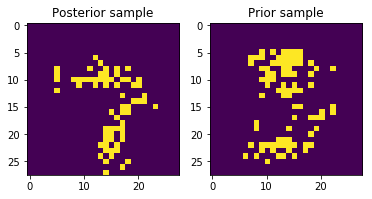

Iteration: 1100 ELBO: -118.705 Examples/s: 1.083e+07
Iteration: 1200 ELBO: -123.848 Examples/s: 1.187e+07
Iteration: 1300 ELBO: -125.863 Examples/s: 1.167e+07
Iteration: 1400 ELBO: -132.654 Examples/s: 1.169e+07
Iteration: 1500 ELBO: -127.965 Examples/s: 1.171e+07
Iteration: 1600 ELBO: -118.578 Examples/s: 1.167e+07
Iteration: 1700 ELBO: -110.291 Examples/s: 1.128e+07
Iteration: 1800 ELBO: -120.615 Examples/s: 1.169e+07
Iteration: 1900 ELBO: -115.444 Examples/s: 1.183e+07
Iteration: 2000 ELBO: -109.076 Examples/s: 1.181e+07


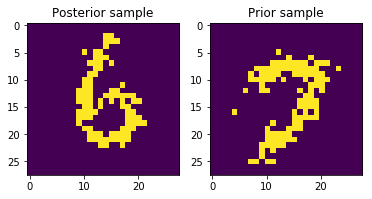

Iteration: 2100 ELBO: -110.125 Examples/s: 1.154e+07
Iteration: 2200 ELBO: -101.299 Examples/s: 1.163e+07
Iteration: 2300 ELBO: -117.737 Examples/s: 1.130e+07
Iteration: 2400 ELBO: -107.424 Examples/s: 1.152e+07
Iteration: 2500 ELBO: -105.359 Examples/s: 1.146e+07
Iteration: 2600 ELBO: -108.017 Examples/s: 1.142e+07
Iteration: 2700 ELBO: -105.489 Examples/s: 1.150e+07
Iteration: 2800 ELBO: -102.931 Examples/s: 1.129e+07
Iteration: 2900 ELBO: -108.975 Examples/s: 1.164e+07
Iteration: 3000 ELBO: -101.836 Examples/s: 1.167e+07


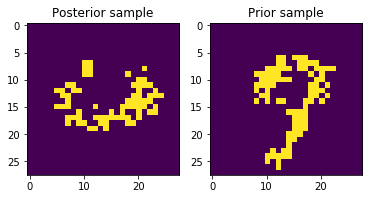

Iteration: 3100 ELBO: -102.005 Examples/s: 1.122e+07
Iteration: 3200 ELBO: -106.879 Examples/s: 1.147e+07
Iteration: 3300 ELBO: -102.612 Examples/s: 1.191e+07
Iteration: 3400 ELBO: -96.813 Examples/s: 1.186e+07
Iteration: 3500 ELBO: -97.796 Examples/s: 1.183e+07
Iteration: 3600 ELBO: -104.069 Examples/s: 1.148e+07
Iteration: 3700 ELBO: -103.338 Examples/s: 1.143e+07
Iteration: 3800 ELBO: -99.388 Examples/s: 1.144e+07
Iteration: 3900 ELBO: -107.018 Examples/s: 1.132e+07
Iteration: 4000 ELBO: -101.676 Examples/s: 1.150e+07


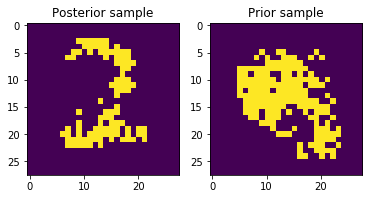

Iteration: 4100 ELBO: -97.778 Examples/s: 1.175e+07
Iteration: 4200 ELBO: -101.897 Examples/s: 1.156e+07
Iteration: 4300 ELBO: -94.645 Examples/s: 1.185e+07
Iteration: 4400 ELBO: -94.824 Examples/s: 1.190e+07
Iteration: 4500 ELBO: -101.232 Examples/s: 1.179e+07
Iteration: 4600 ELBO: -91.991 Examples/s: 1.213e+07
Iteration: 4700 ELBO: -96.230 Examples/s: 1.191e+07
Iteration: 4800 ELBO: -96.739 Examples/s: 1.241e+07
Iteration: 4900 ELBO: -104.932 Examples/s: 1.161e+07
Iteration: 5000 ELBO: -101.914 Examples/s: 1.166e+07


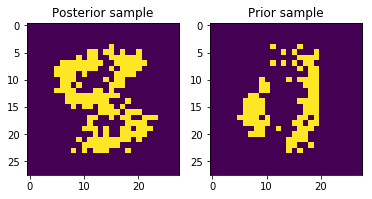

Iteration: 5100 ELBO: -91.746 Examples/s: 1.172e+07
Iteration: 5200 ELBO: -94.953 Examples/s: 1.179e+07
Iteration: 5300 ELBO: -96.010 Examples/s: 1.169e+07
Iteration: 5400 ELBO: -102.636 Examples/s: 1.198e+07
Iteration: 5500 ELBO: -89.464 Examples/s: 1.166e+07
Iteration: 5600 ELBO: -91.096 Examples/s: 1.186e+07
Iteration: 5700 ELBO: -99.129 Examples/s: 1.182e+07
Iteration: 5800 ELBO: -87.192 Examples/s: 1.171e+07
Iteration: 5900 ELBO: -92.808 Examples/s: 1.179e+07
Iteration: 6000 ELBO: -94.176 Examples/s: 1.193e+07


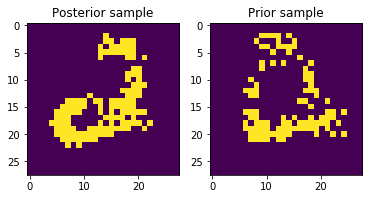

Iteration: 6100 ELBO: -94.011 Examples/s: 1.149e+07
Iteration: 6200 ELBO: -92.812 Examples/s: 1.156e+07
Iteration: 6300 ELBO: -90.016 Examples/s: 1.122e+07
Iteration: 6400 ELBO: -96.862 Examples/s: 1.117e+07
Iteration: 6500 ELBO: -87.417 Examples/s: 1.163e+07
Iteration: 6600 ELBO: -94.000 Examples/s: 1.147e+07
Iteration: 6700 ELBO: -97.242 Examples/s: 1.147e+07
Iteration: 6800 ELBO: -87.779 Examples/s: 1.157e+07
Iteration: 6900 ELBO: -98.809 Examples/s: 1.175e+07
Iteration: 7000 ELBO: -88.273 Examples/s: 1.161e+07


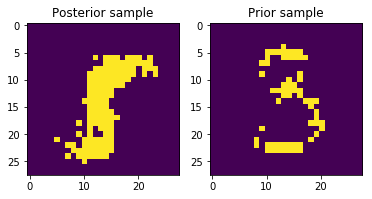

Iteration: 7100 ELBO: -87.916 Examples/s: 1.163e+07
Iteration: 7200 ELBO: -86.134 Examples/s: 1.146e+07
Iteration: 7300 ELBO: -91.525 Examples/s: 1.165e+07
Iteration: 7400 ELBO: -94.199 Examples/s: 1.169e+07
Iteration: 7500 ELBO: -94.125 Examples/s: 1.160e+07
Iteration: 7600 ELBO: -100.188 Examples/s: 1.178e+07
Iteration: 7700 ELBO: -85.999 Examples/s: 1.158e+07
Iteration: 7800 ELBO: -90.856 Examples/s: 1.155e+07
Iteration: 7900 ELBO: -85.855 Examples/s: 1.155e+07
Iteration: 8000 ELBO: -88.127 Examples/s: 1.190e+07


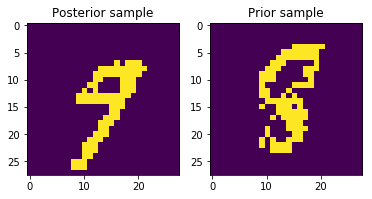

Iteration: 8100 ELBO: -90.874 Examples/s: 1.118e+07
Iteration: 8200 ELBO: -92.233 Examples/s: 1.166e+07
Iteration: 8300 ELBO: -95.609 Examples/s: 1.148e+07
Iteration: 8400 ELBO: -85.463 Examples/s: 1.128e+07
Iteration: 8500 ELBO: -97.038 Examples/s: 1.136e+07
Iteration: 8600 ELBO: -95.602 Examples/s: 1.122e+07
Iteration: 8700 ELBO: -89.140 Examples/s: 1.167e+07
Iteration: 8800 ELBO: -89.722 Examples/s: 1.151e+07
Iteration: 8900 ELBO: -86.956 Examples/s: 1.164e+07
Iteration: 9000 ELBO: -87.270 Examples/s: 1.164e+07


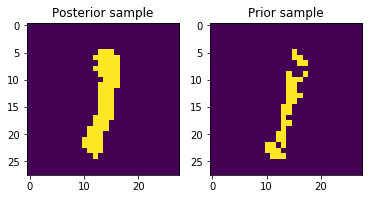

Iteration: 9100 ELBO: -89.507 Examples/s: 1.147e+07
Iteration: 9200 ELBO: -92.469 Examples/s: 1.166e+07
Iteration: 9300 ELBO: -94.381 Examples/s: 1.169e+07
Iteration: 9400 ELBO: -93.184 Examples/s: 1.178e+07
Iteration: 9500 ELBO: -95.864 Examples/s: 1.140e+07
Iteration: 9600 ELBO: -90.629 Examples/s: 1.062e+07
Iteration: 9700 ELBO: -92.728 Examples/s: 1.158e+07
Iteration: 9800 ELBO: -86.942 Examples/s: 1.150e+07
Iteration: 9900 ELBO: -92.241 Examples/s: 1.184e+07


In [4]:
def train():    
    # Train a Variational Autoencoder on MNIST

    # We need to reset the graph between multiple runs of the cell to avoid
    # TF complaining about creating duplicate variables.
    tf.reset_default_graph()
    
    # Input placeholders
    with tf.name_scope('data'):
        x = tf.placeholder(tf.float32, [None, 28, 28, 1])     
    
    with tf.variable_scope('variational'):
        # Given x, get the mean and variance of q(z|x).
        q_mu, q_sigma = inference_network(x=x,
                                          latent_dim=FLAGS.latent_dim,
                                          hidden_size=FLAGS.hidden_size)
        
        with st.value_type(st.SampleValue()):
            # We now draw a sample from z ~ q(z|x).
            #
            # This is the key to this practical. We effectively transform Normal(0,1)
            # noise that it *outside* the computation graph, to represent a sample
            # from Normal(q_mu, q_sigma).
            #
            #     This is the REPARAMETERIZATION TRICK.
            
            q_z = st.StochasticTensor(distributions.Normal(loc=q_mu, scale=q_sigma))
            
            # Challenge: Can you write
            #
            # q_z = ...
            #
            # by using tf.random_normal(...) and then transforming it?
            
    with tf.variable_scope('model'):
        # The likelihood is Bernoulli-distributed with logits given by the
        # generative network
        p_x_given_z_logits = generative_network(z=q_z,
                                                hidden_size=FLAGS.hidden_size)

        p_x_given_z = distributions.Bernoulli(logits=p_x_given_z_logits)
        
        posterior_predictive_samples = p_x_given_z.sample()

    # You can ignore the "Take samples" bits for now, until the end of the prac.
    # Take samples from the prior
    with tf.variable_scope('model', reuse=True):
        p_z = distributions.Normal(loc=np.zeros(FLAGS.latent_dim, dtype=np.float32),
                                                scale=np.ones(FLAGS.latent_dim, dtype=np.float32))
        p_z_sample = p_z.sample(FLAGS.n_samples)
        p_x_given_z_logits = generative_network(z=p_z_sample,
                                                hidden_size=FLAGS.hidden_size)
        prior_predictive = distributions.Bernoulli(logits=p_x_given_z_logits)
        prior_predictive_samples = prior_predictive.sample()     

    # You can ignore the "Take samples" bits for now, until the end of the prac.
    # Take samples from the prior with a placeholder
    with tf.variable_scope('model', reuse=True):
        z_input = tf.placeholder(tf.float32, [None, FLAGS.latent_dim])
        p_x_given_z_logits = generative_network(z=z_input,
                                                hidden_size=FLAGS.hidden_size)
        prior_predictive_inp = distributions.Bernoulli(logits=p_x_given_z_logits)
        prior_predictive_inp_sample = prior_predictive_inp.sample()

    # The juice! Convince yourself that you understand the lines below.    
    # Build the evidence lower bound (ELBO) or the negative loss
    kl = tf.reduce_sum(distributions.kl_divergence(q_z.distribution, p_z), 1)
    expected_log_likelihood = tf.reduce_sum(p_x_given_z.log_prob(x),
                                            [1, 2, 3])
    elbo = tf.reduce_sum(expected_log_likelihood - kl, 0)

    # Challenge. Can you see how the four lines above relate to the mathematical
    #                        expressions you've encountered?
    # Answer: ...
    
    optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)

    train_op = optimizer.minimize(-elbo)

    init_op = tf.global_variables_initializer()

    # Run training
    sess = tf.InteractiveSession()
    sess.run(init_op)
 
    #mnist = read_data_sets(FLAGS.data_dir, one_hot=True)
    mnist = input_data.read_data_sets(FLAGS.data_dir, one_hot=True)

    # Get fixed MNIST digits for plotting posterior means during training
    np_x_fixed, np_y = mnist.test.next_batch(5000)
    np_x_fixed = np_x_fixed.reshape(5000, 28, 28, 1)
    np_x_fixed = (np_x_fixed > 0.5).astype(np.float32)

    for i in range(N_ITERATIONS):
        # Re-binarize the data at every batch; this improves results
        np_x, _ = mnist.train.next_batch(FLAGS.batch_size)
        np_x = np_x.reshape(FLAGS.batch_size, 28, 28, 1)
        np_x = (np_x > 0.5).astype(np.float32)
        sess.run(train_op, {x: np_x})
                
        t0 = time.time()
        if i % 100 == 0:            
            np_elbo = sess.run(elbo, feed_dict={x: np_x})                        
                     
            print('Iteration: {0:d} ELBO: {1:.3f} Examples/s: {2:.3e}'.format(
                    i,
                    np_elbo / FLAGS.batch_size,
                    FLAGS.batch_size * FLAGS.print_every / (time.time() - t0)))
            t0 = time.time()            

        if i % 1000 == 0 and i > 0: 
            # Get samples
            np_posterior_samples, np_prior_samples = sess.run(
                    [posterior_predictive_samples, prior_predictive_samples],
                    feed_dict={x: np_x})                     
            
            for k in range(1):     # range(FLAGS.n_samples):                
                # Plot the data using Matplotlib
                fig = plt.figure()    
                plt.subplot(1, 2, 1)                
                plt.imshow(np_posterior_samples[k, :, :, 0])                
                plt.title('Posterior sample')                
                
                plt.subplot(1, 2, 2)                
                plt.imshow(np_prior_samples[k, :, :, 0])                
                plt.title('Prior sample')
                plt.show()                                    

train()


# Final discussion

**Doing better**

* At this point, you might realize that the prior samples don't all look like perfectly formed digits.

* Now, think about the discussion about the "data manifold" from the Deep Generative Models lecture. Do you think $p(z)$ actually captured the data manifold, using $p_{\theta}(x | z)$ as a generative model?

* What will you do to make the randomly generated digits (prior samples) look more realistic? Train for longer? Make the network deeper?

**Objective function**

* Do you think the ELBO (evidence lower bound) is the right measure of success? Why? Why not?

* Do you think the ELBO has pathological flaws? Or is it a convenient tool?

* Do you think a data manifold should be described by a Gaussian distribution?

* In which other ways will you solve the inference problem, finding $p_{\theta}(z | x)$?

* In which other ways will you solve the learning problem, finding the $\theta$ that maximizes $p_{\theta}(x)$?

# NB: Before you go (5min)

Pair up with someone else and go through the questions in "Learning Objectives" at the top. Take turns explaining each of these to each other, and be sure to ask the tutors if you're both unsure!

# Acknowledgements

* Based on Jaan Altosaar's VAE implementation: https://github.com/altosaar/vae/blob/master/vae.py

# Feedback

Please send any bugs and comments to dli-practicals@googlegroups.com.